## Load the data into RAM

CSV


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# `np.uint8` would suffice to represent the greyscale value for each pixel 
# but because sklearn uses double precision internally for a lot of algorithms, 
# we're gonna use `np.float64` from the beginning.
test_data = np.genfromtxt('mnist_test.csv', delimiter=',', dtype=np.float64)
train_data = np.genfromtxt('mnist_train.csv', delimiter=',', dtype=np.float64)

# first column of each row is the digit we want to recognize later
y_test = test_data[:,0]
# the rest of the row's entries are the 28x28 greyscale values
X_test = test_data[:,1:].reshape((-1,28*28))

# same for the training data
y_train = train_data[:,0]
X_train = train_data[:,1:].reshape((-1,28*28))

# see what we end up with
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

## Feature selection

First we examine the data by looking at some digits.

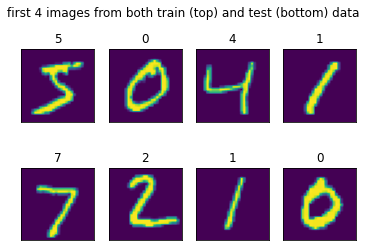

In [2]:
samples = 4
f, axes = plt.subplots(2, samples)
f.suptitle(f'first {samples} images from both train (top) and test (bottom) data')

for i in range(samples):
    # top row
    axes[0][i].imshow(X_train[i].reshape(28,28))
    axes[0][i].set_title("{:.0f}".format(y_train[i]))

    # bottom row
    axes[1][i].imshow(X_test[i].reshape(28,28))
    axes[1][i].set_title("{:.0f}".format(y_test[i]))

    # get rid of axes
    axes[0][i].set_xticks(())
    axes[0][i].set_yticks(())
    axes[1][i].set_xticks(())
    axes[1][i].set_yticks(())

### We investigate which pixel carry information and which ones don't.

By looking at the mean of the training set as image we can clearly see that the pixel towards the edge of the image are more likely to be the same for every digit. Meaning these features really don't have much impact.

> The classes in the sklearn.feature_selection module can be used for feature selection/dimensionality reduction on sample sets, either to improve estimators’ accuracy scores or to boost their performance on very high-dimensional datasets.
>
>VarianceThreshold is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e. features that have the same value in all samples.
>
> -- <cite>[sklearn](https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection-using-selectfrommodel)</cite>

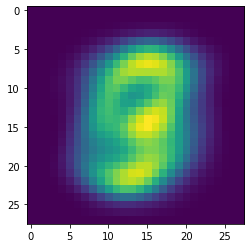

In [3]:
# visualize mean of the training set
plt.imshow(np.mean(X_train.reshape(-1,28,28), axis=0))

In [4]:
from sklearn.feature_selection import VarianceThreshold
# For now we'll just use the default elimination of zero-variance features.
selector = VarianceThreshold()
# TODO: How to get y_transformed???
X_transformed = selector.fit_transform(X_train, y_train)
# we already eliminated 67 features with default=0 threshold
X_transformed.shape

(60000, 717)

## Preprocessing
> The sklearn.preprocessing package provides several common utility functions and transformer classes to change raw feature vectors into a representation that is more suitable for the downstream estimators.
>
> Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.
>
> -- <cite>[sklearn](https://sklearn.org/modules/preprocessing.html#preprocessing)</cite>

So let's standardize features by removing the mean and scaling to unit variance

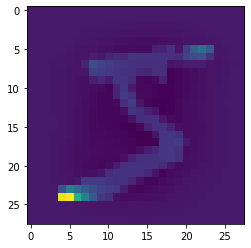

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Standardize features by removing the mean and scaling to unit variance
X_scaled = scaler.fit_transform(X_transformed, y_train)
# example of a scaled digit. inverse feature elimination first
# let's see what the scaling did to our data
plt.imshow(selector.inverse_transform(X_scaled)[0].reshape(28,28))

## Classify Zero digits
For now we only want to tell '0' from other digits. We need a binary classifier for zero/non-zero.
We'll try a LogisticRegression first.

In [6]:
# turn target values into booleans
y_binary = y_train == 0

from sklearn.linear_model import LogisticRegression

# Turn up tolerance for faster convergence
train_samples = X_scaled.shape[0]
clf = LogisticRegression(C=50. / train_samples,
                         multi_class='multinomial',
                         penalty='l1', solver='saga', tol=0.1)
clf.fit(X_scaled, y_binary)

LogisticRegression(C=0.0008333333333333334, multi_class='multinomial',
                   penalty='l1', solver='saga', tol=0.1)

In [7]:
from sklearn.metrics import f1_score
# reapply pre-processing to test data
# this is cumbersome that's why we're gonna use a pipeline the next time.
X_test_scaled = scaler.transform(selector.transform(X_test))
y_test_binary = y_test==0
score = clf.score(X_test_scaled, y_test_binary)
y_pred = clf.predict(X_test_scaled)
f1 = f1_score(y_test_binary,y_pred)
# Let's see how we did.
score, f1

(0.9723, 0.8519508284339925)

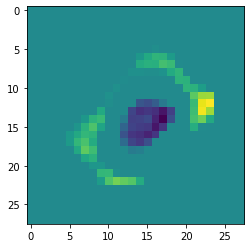

In [8]:
# lets look at the coefficients of the model
# one can definetly recognize a '0' in there
coef = clf.coef_.copy()
plt.imshow(selector.inverse_transform(coef).reshape(28,28))

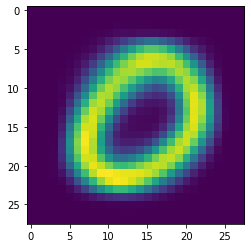

In [9]:
# mean of the digits we predicted to be zeroes
plt.imshow(np.mean(X_test[y_pred], axis=0).reshape(28,28))

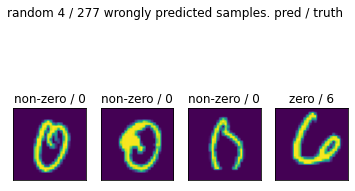

In [10]:
# inspect some we predicted wrong
X_pred_wrong = X_test[np.logical_not(y_pred == y_test_binary)]
# if they are actually a zero
actual_digit = y_test[np.logical_not(y_pred == y_test_binary)]
# holds if we wrongly predicted a zero or wrongly predicted a non-zero
y_pred_wrong = y_pred[np.logical_not(y_pred == y_test_binary)]

samples = 4
f, axes = plt.subplots(1, samples)
f.suptitle(f'random {samples} / {len(y_pred_wrong)} wrongly predicted samples. pred / truth')

for i in range(samples):
    idx = np.random.randint(len(y_pred_wrong))
    we_predicted = "zero" if y_pred_wrong[idx] else "non-zero"
    axes[i].imshow(X_pred_wrong[idx].reshape(28,28))
    axes[i].set_title(we_predicted + " / " + "{:.0f}".format(actual_digit[idx]))

    # get rid of axes
    axes[i].set_xticks(())
    axes[i].set_yticks(())

Text(0.5, 1.0, 'digit is not zero')

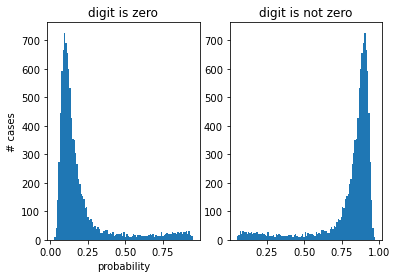

In [11]:
# clf.classes_
digit_not_zero_proba = clf.predict_proba(X_test_scaled)[:,0]
digit_is_zero_proba = clf.predict_proba(X_test_scaled)[:,1]

f, (ax1, ax2) = plt.subplots(1, 2)

ax1.hist(digit_is_zero_proba, bins=100)
ax1.set_title("digit is zero")
ax1.set_ylabel("# cases")
ax1.set_xlabel("probability")
ax2.hist(digit_not_zero_proba, bins=100)
ax2.set_title("digit is not zero")

In [12]:
clf.predict_proba(X_test_scaled)
clf.classes_

array([False,  True])

Our model seems relatively unsure to label a digit as 'zero'.
We can also find a lot of zeroes labeled as 'non-zero' when inspecting the wrongly labeled digits (above).

Nevertheless not too shabby considering the time spent fitting/learning. Let's move on.

In [13]:
# try with Gradient Descent
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss="log", penalty="l2")
clf.fit(X_scaled, y_binary)

SGDClassifier(loss='log')

In [14]:
score = clf.score(X_test_scaled, y_test_binary)
y_pred_binary = clf.predict(X_test_scaled)
# Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label).
f1 = f1_score(y_test_binary,y_pred_binary)
# much better scores
print('accuracy %f' %score)
print('f1 score %f' %f1)

accuracy 0.989400
f1 score 0.945191


Text(0.5, 1.0, 'digit is not zero')

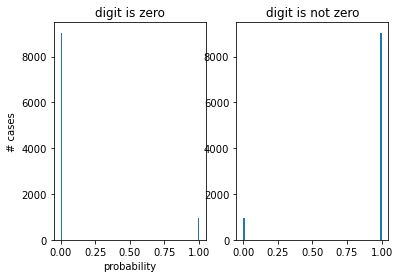

In [15]:
digit_not_zero_proba = clf.predict_proba(X_test_scaled)[:,0]
digit_is_zero_proba = clf.predict_proba(X_test_scaled)[:,1]

f, (ax1, ax2) = plt.subplots(1, 2)

ax1.hist(digit_is_zero_proba, bins=100)
ax1.set_title("digit is zero")
ax1.set_ylabel("# cases")
ax1.set_xlabel("probability")
ax2.hist(digit_not_zero_proba, bins=100)
ax2.set_title("digit is not zero")

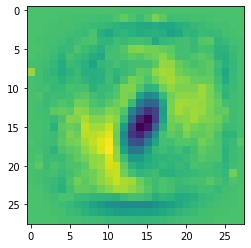

In [16]:
# a quick look a the coefficients
coef = clf.coef_.copy()
plt.imshow(selector.inverse_transform(coef).reshape(28,28))

## Classify all digits
Now we want to train a model that can tell if the drawn digit is a 0/1/2...8/9. We're gonna use a One-vs-rest model. A binary problem will be fit for each label.

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
clf = Pipeline([
#     use a threshold this time
  ('feature_selection', VarianceThreshold(threshold=(.4))),
  ('feature_scaling', StandardScaler()),
#     use OVRC to parallelize the 10 binary fittings
  ('classification', OneVsRestClassifier(
      #       use default values of LogisticRegression but with ovr
      estimator=LogisticRegression(multi_class='ovr'),
      #       use all cores available
      n_jobs=-1))
])

clf.fit(X_train, y_train)

Pipeline(steps=[('feature_selection', VarianceThreshold(threshold=0.4)),
                ('feature_scaling', StandardScaler()),
                ('classification',
                 OneVsRestClassifier(estimator=LogisticRegression(multi_class='ovr'),
                                     n_jobs=-1))])

In [18]:
score = clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
# "weighted" accounts for class imbalance by computing the average of binary metrics in which each class’s score
# is weighted by its presence in the true data sample.
f1 = f1_score(y_test,y_pred, average='weighted')
# scores
score, f1

(0.9182, 0.9179629873521377)

## Analysis
Let's get some metrics and then draw conclusions.

In [20]:
from sklearn.metrics import accuracy_score

# accuracy and f1 score for each binary classification
def accuracy_for_digit(d):
    y_digit_d = y_test == d
    # use boolean sample weight to only select the digits in question
    return accuracy_score(y_test, y_pred, sample_weight=y_digit_d)

digits = range(10)
accs = []
for digit in digits:
    accs += [accuracy_for_digit(digit)]

accs = np.array(accs)
f1s = f1_score(y_test,y_pred, average=None)

# mean of probabilities for each label (pos/neg) of each binary classification
def mean_proba_digit(d):
    # shape i.e (1013,10) .. (samples,classes)
    proba_per_class = clf.predict_proba(X_test[y_test==d])
    pos = np.mean(proba_per_class[:,d])
    # probabilities for each class except digit d .. in other words neg proba
    proba_per_class_except_d = np.append(proba_per_class[:,:d],proba_per_class[:,d+1:],axis=1)
    # first sum for each sample the probas for not being digit d, then mean those means over all samples
    # probably 1-pos woulda been better? idk.
    # lol turns out it is exactly the same ... all the complex indexing for nothing :) 
    neg = np.mean(np.sum(proba_per_class_except_d,axis=1))
    return neg, pos

# fill np arrays
mean_proba_digits_neg = []
mean_proba_digits_pos = []
for i in digits:
    neg, pos = mean_proba_digit(i)
    mean_proba_digits_neg += [neg]
    mean_proba_digits_pos += [pos]
    
mean_neg = np.array(mean_proba_digits_neg)
mean_pos = np.array(mean_proba_digits_pos)

In [21]:
# show metrics in table
import pandas as pd
df = pd.DataFrame()

df['accuracy'] = accs
df['f1 score'] = f1s
df['mean neg proba'] = mean_neg
df['mean pos proba'] = mean_pos

df

,accuracy,f1 score,mean neg proba,mean pos proba
0,0.979592,0.963372,0.077553,0.922447
1,0.978855,0.966928,0.125335,0.874665
2,0.885659,0.909905,0.188003,0.811997
3,0.908911,0.900441,0.178052,0.821948
4,0.930754,0.926508,0.180190,0.819810
5,0.863229,0.875000,0.235098,0.764902
6,0.948852,0.942946,0.102296,0.897704
7,0.916342,0.919024,0.172707,0.827293
8,0.873717,0.872821,0.210442,0.789558
9,0.885035,0.893000,0.207145,0.792855


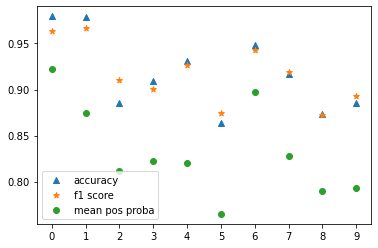

In [22]:
plt.scatter(digits,accs,label='accuracy',marker='^')
plt.scatter(digits,f1s,label='f1 score',marker='*')
plt.scatter(digits,mean_pos,label='mean pos proba',marker='o')
plt.xticks(digits)
plt.legend(loc='best')

Text(0.5, 1.0, 'wrongly predicted digits with OVR LogisticRegression')

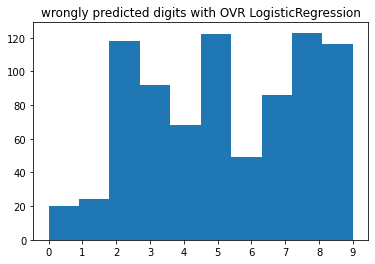

In [23]:
wrongly_pred = y_test[np.logical_not(y_pred == y_test)]
plt.hist(wrongly_pred)
plt.xticks(digits)
plt.title('wrongly predicted digits with OVR LogisticRegression')

We can see that our model has a hard time predicting the digits `5` and `8`. But it's really good at predicting digits `0` and `1`.

Text(0.5, 0.98, 'Classification vectors for all digits')

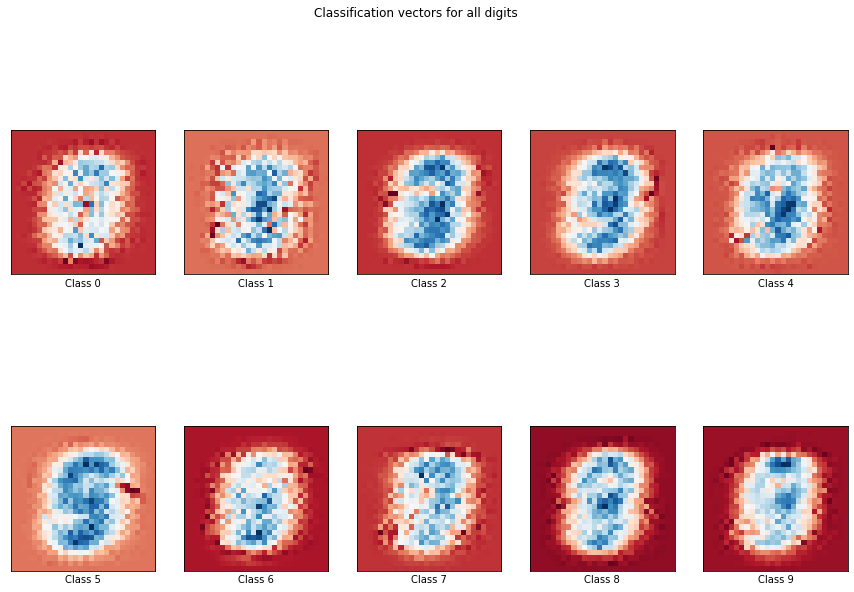

In [24]:
# OneVsRestClassifier created 10 binary LogisticRegression estimators for us
# i.e clf['classification'].estimators_

plt.figure(figsize=(15, 10))
for i in range(10):
    # get references and reverse transform coef through the pipeline
    coef = clf['classification'].estimators_[i].coef_.copy()
    coef = clf['feature_scaling'].inverse_transform(coef)
    coef = clf['feature_selection'].inverse_transform(coef)
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(coef.reshape(28, 28), cmap=plt.cm.RdBu)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Class %i' % i)
plt.suptitle('Classification vectors for all digits')

because we tried to get rid of the outer pixel influence via the VarianceThreshold it surprises me that they are not the same colour for all classes. It seems like some of the classes weigh the outer pixel more than others. One could try to optimize there.

## Detect my own handwriting

For this i drew some digits on my tablet. I created a new 24 bit greyscale canvas in GIMP and scaled down my digits onto it.

[3.0, 3.0, 2.0, 4.0]

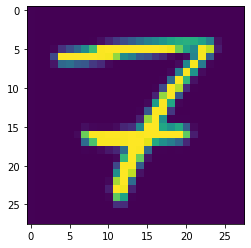

In [25]:
from PIL import Image

pred = []

im = Image.open("one.bmp")
p = np.array(im, dtype=np.float64).reshape(1,-1)
plt.imshow(p)
one = p.reshape(1,-1)
pred += [clf.predict(one)[0]] # success

im = Image.open("three1.bmp")
p = np.array(im)
plt.imshow(p)
three1 = p.reshape(1,-1)
pred += [clf.predict(three1)[0]] # success

im = Image.open("three2.bmp")
p = np.array(im)
plt.imshow(p)
three2 = p.reshape(1,-1)
pred += [clf.predict(three2)[0]] # success

im = Image.open("seven.bmp")
p = np.array(im)
plt.imshow(p)
seven = p.reshape(1,-1)
pred += [clf.predict(seven)[0]] # success
# # fail .. predicts as 4 because i have a different writing style for this digit
# # very clear when we look at the mean for all 7 digits of the training set

pred

## Linear SVM
We will test a Support Vector Machine next.

In [26]:
from sklearn.svm import LinearSVC

clf = Pipeline([
# use a much higher threshold this time
  ('feature_selection', VarianceThreshold(threshold=(100))),
  ('feature_scaling', StandardScaler()),
    # this requires quite a bit of installed ram
  ('classification', OneVsRestClassifier(
    # Prefer dual=False when n_samples > n_features.
      estimator=LinearSVC(dual=False),
    # use all cores available
      n_jobs=-1)),
], verbose=True)

clf.fit(X_train, y_train)

Pipeline(steps=[('feature_selection', VarianceThreshold(threshold=100)),
                ('feature_scaling', StandardScaler()),
                ('classification',
                 OneVsRestClassifier(estimator=LinearSVC(dual=False),
                                     n_jobs=-1))])

In [27]:
clf.score(X_test,y_test)

0.9172

521 / 784 features selected


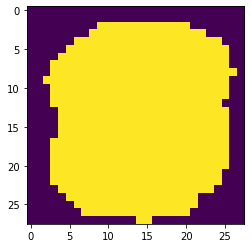

In [28]:
# lets find out more about the VarianceThreshold feature selection
# play with the threshold param and see how the image changes
selector = VarianceThreshold(threshold=(100))
selector.fit(X_test)
zeros = np.zeros(28*28)
selected = selector.transform(zeros.reshape(1, -1))
selected += 255
print('%i / 784 features selected' % selected.shape[1])
selected_features = selector.inverse_transform(selected)
plt.imshow(selected_features.reshape(28,28))

In [31]:
from sklearn.svm import SVC

deg3polySVC = Pipeline([
# use a much higher threshold this time
  ('feature_selection', VarianceThreshold(threshold=(100))),
  ('feature_scaling', StandardScaler()),
    # this requires quite a bit of installed ram
  ('classification', OneVsRestClassifier(
    # Prefer dual=False when n_samples > n_features.
      estimator=SVC(
          # If you have enough RAM available, it is recommended to set cache_size to a higher value
          cache_size=1000,
          # https://en.wikipedia.org/wiki/MNIST_database has an entry for a poly deg9 kernel SVM with a good score
          kernel='poly',
          degree=3,
          verbose=True
      ),
    # use all cores available
      n_jobs=-1)),
],verbose=True)
deg3polySVC.fit(X_train, y_train)

Pipeline(steps=[('feature_selection', VarianceThreshold(threshold=100)),
                ('feature_scaling', StandardScaler()),
                ('classification',
                 OneVsRestClassifier(estimator=SVC(cache_size=1000, degree=4,
                                                   kernel='poly',
                                                   verbose=True),
                                     n_jobs=-1))])

In [32]:
deg3polySVC.score(X_test,y_test) # 0.9753 with deg=3, 0.9703 with deg 4 (takes time!)

0.9703

In [33]:
rbfSVC = Pipeline([
# use a much higher threshold this time
#   ('feature_selection', VarianceThreshold(threshold=(100))),
  ('feature_scaling', StandardScaler()),
    # this requires quite a bit of installed ram
  ('classification', OneVsRestClassifier(
    # Prefer dual=False when n_samples > n_features.
      estimator=SVC(
          # If you have enough RAM available, it is recommended to set cache_size to a higher value
          cache_size=1000,
          kernel='rbf',
          verbose=True
      ),
    # use all cores available
      n_jobs=-1)),
],verbose=True)
rbfSVC.fit(X_train, y_train)

[Pipeline] ... (step 1 of 2) Processing feature_scaling, total=   1.8s
[Pipeline] .... (step 2 of 2) Processing classification, total=21.1min


Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('classification',
                 OneVsRestClassifier(estimator=SVC(cache_size=1000),
                                     n_jobs=-1))],
         verbose=True)

In [34]:
rbfSVC.score(X_test,y_test)

0.9681

In [35]:
sigmoidSVC = Pipeline([
# use a much higher threshold this time
#   ('feature_selection', VarianceThreshold(threshold=(100))),
  ('feature_scaling', StandardScaler()),
    # this requires quite a bit of installed ram
  ('classification', OneVsRestClassifier(
    # Prefer dual=False when n_samples > n_features.
      estimator=SVC(
          # If you have enough RAM available, it is recommended to set cache_size to a higher value
          cache_size=1000,
          kernel='sigmoid',
          verbose=True
      ),
    # use all cores available
      n_jobs=-1)),
],verbose=True)
sigmoidSVC.fit(X_train, y_train)
sigmoidSVC.score(X_test,y_test)

[Pipeline] ... (step 1 of 2) Processing feature_scaling, total=   1.8s
[Pipeline] .... (step 2 of 2) Processing classification, total=19.1min


0.817

In [ ]:
# conda activate notebooks

In [ ]:
# pip install scipy scikit-learn